In [317]:
import cv2
import numpy as np
import os
import json
from matplotlib import pyplot as plt

with open("data/input.json", "r") as f:
    input_data = json.load(f)

image_paths = input_data["image_files"]
image_num = 30


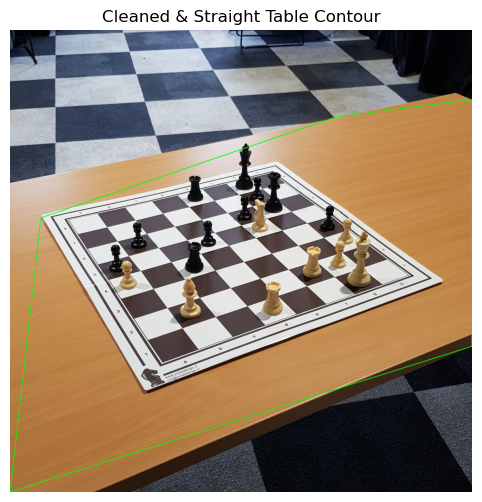

In [ ]:
image = cv2.imread(image_paths[image_num])

hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

lower_brown = np.array([0, 25, 50])     # Slightly lower V min
upper_brown = np.array([30, 255, 200])  # Cap V max to avoid glare/reflection


mask = cv2.inRange(hsv, lower_brown, upper_brown)

kernel = np.ones((5, 5), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

table_contour = max(contours, key=cv2.contourArea)

contour_image = image.copy()
cv2.drawContours(contour_image, [table_contour], -1, (0, 255, 0), 3)

contour_rgb = cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.title("Detected Table Contour")
plt.imshow(contour_rgb)
plt.axis('off')
plt.show()


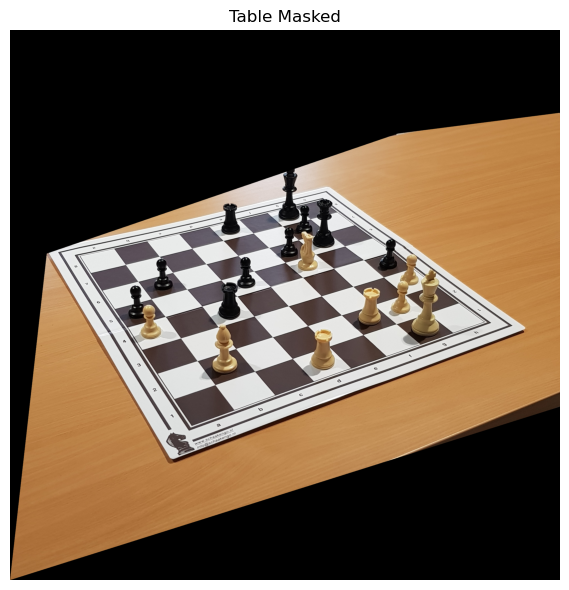

In [319]:
table_mask = np.zeros_like(image)
cv2.drawContours(table_mask, [approx], -1, (255, 255, 255), thickness=cv2.FILLED)
masked_image = cv2.bitwise_and(image, table_mask)

masked_rgb = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)

# Display both results side-by-side
plt.figure(figsize=(12, 6))

plt.plot(1, 2, 2)
plt.title("Table Masked")
plt.imshow(masked_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()


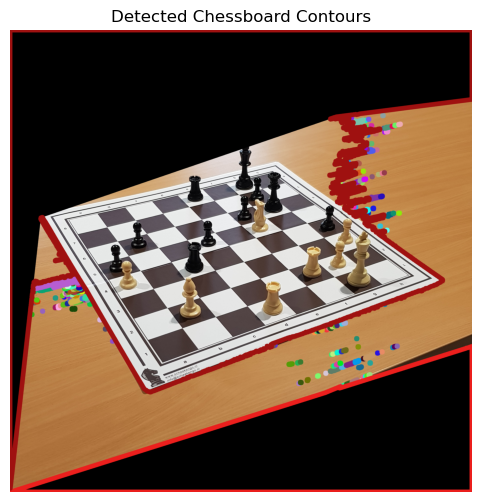

In [320]:
hsv = cv2.cvtColor(masked_image, cv2.COLOR_BGR2HSV)

table_color_mask = cv2.inRange(hsv, lower_brown, upper_brown)
chessboard_mask = cv2.bitwise_not(table_color_mask)

kernel = np.ones((3, 3), np.uint8)
chessboard_mask = cv2.morphologyEx(chessboard_mask, cv2.MORPH_CLOSE, kernel)
chessboard_mask = cv2.morphologyEx(chessboard_mask, cv2.MORPH_OPEN, kernel, iterations=2)

contours_, _ = cv2.findContours(chessboard_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
height, width = chessboard_mask.shape[:2]


# draw contours on the original image
contour_image = masked_image.copy()
for contour in contours_:
    random_color = tuple(np.random.randint(0, 255, 3).tolist())

    cv2.drawContours(contour_image, [contour], -1, random_color, 30)
contour_rgb = cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.title("Detected Chessboard Contours")
plt.imshow(contour_rgb)
plt.axis('off')
plt.show()




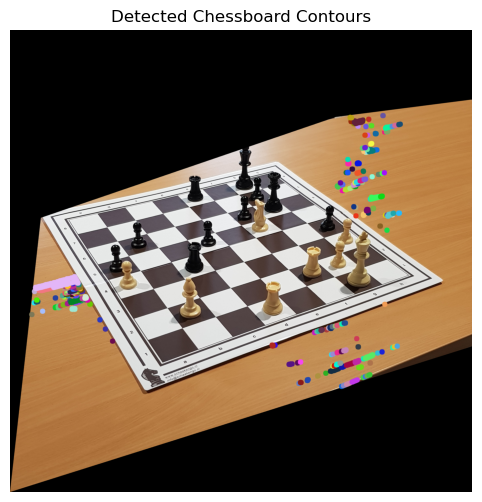

In [321]:

def is_touching_border(contour, width, height):
    for point in contour:
        x, y = point[0]
        if x <= 1 or y <= 1 or x >= width - 2 or y >= height - 2:
            return True
    return False

contours = [cnt for cnt in contours_ if not is_touching_border(cnt, width, height)]


# draw contours on the original image
contour_image = masked_image.copy()
for contour in contours:
    random_color = tuple(np.random.randint(0, 255, 3).tolist())

    cv2.drawContours(contour_image, [contour], -1, random_color, 30)
contour_rgb = cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.title("Detected Chessboard Contours")
plt.imshow(contour_rgb)
plt.axis('off')
plt.show()


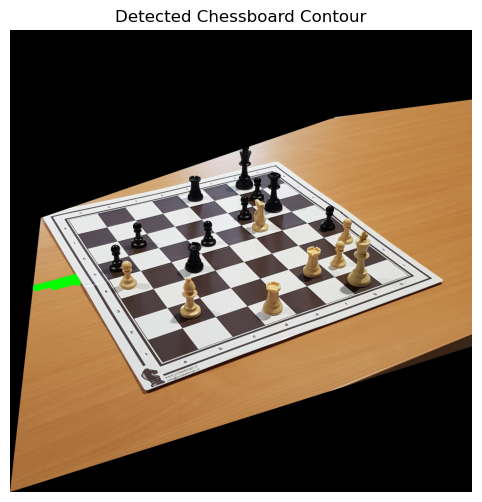

In [322]:
chessboard_countor = max(contours, key=cv2.contourArea)

# draw contours on the original image
contour_image = masked_image.copy()
cv2.drawContours(contour_image, [chessboard_countor], -1, (0, 255, 0), 30)
contour_rgb = cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.title("Detected Chessboard Contour")
plt.imshow(contour_rgb)
plt.axis('off')
plt.show()

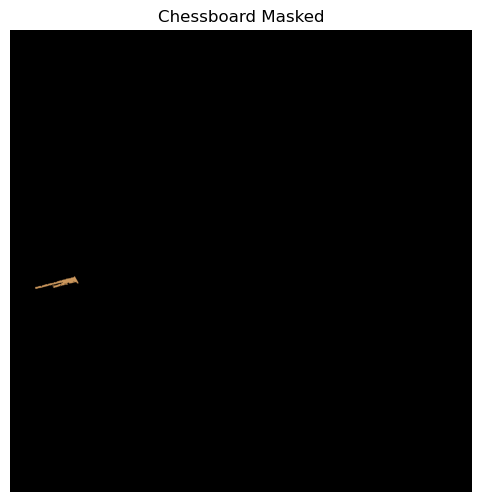

In [323]:
## aply mask to the image
chessboard_mask = np.zeros_like(image)
cv2.drawContours(chessboard_mask, [chessboard_countor], -1, (255, 255, 255), thickness=cv2.FILLED)
masked_image = cv2.bitwise_and(image, chessboard_mask)
masked_rgb = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.title("Chessboard Masked")
plt.imshow(masked_rgb)
plt.axis('off')
plt.show()

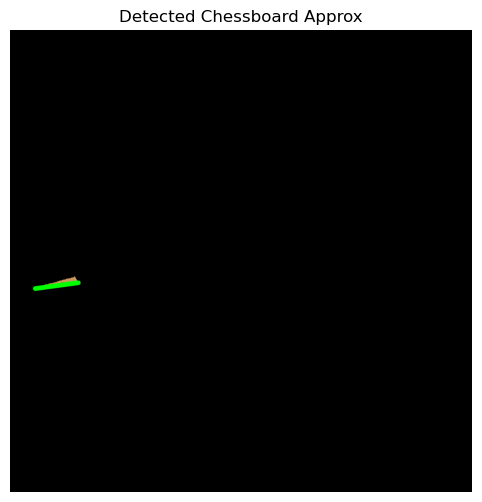

In [324]:
approx = cv2.approxPolyDP(chessboard_countor, 0.06 * cv2.arcLength(chessboard_countor, True), True)

# draw contours on the original image
contour_image = masked_image.copy()
cv2.drawContours(contour_image, [approx], -1, (0, 255, 0), 30)
contour_rgb = cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.title("Detected Chessboard Approx")
plt.imshow(contour_rgb)
plt.axis('off')
plt.show()

In [325]:
corners = approx.reshape(4, 2)
corners = corners[np.argsort(corners[:, 0])]


left_corners = corners[:2]

top_left = left_corners[np.argmin(left_corners[:, 1])]
bottom_left = left_corners[np.argmax(left_corners[:, 1])]

right_corners = corners[2:]
top_right = right_corners[np.argmin(right_corners[:, 1])]
bottom_right = right_corners[np.argmax(right_corners[:, 1])]


ordered_corners = [top_left, top_right, bottom_right, bottom_left]

# draw contours on the original image
corner_image = masked_image.copy()
for corner in ordered_corners:
    cv2.circle(corner_image, tuple(corner), 50, (255,0,0), -1)

corner_rgb = cv2.cvtColor(corner_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.title("Detected Chessboard Corners")
plt.imshow(corner_rgb)
plt.axis('off')
plt.show()

ValueError: cannot reshape array of size 4 into shape (4,2)

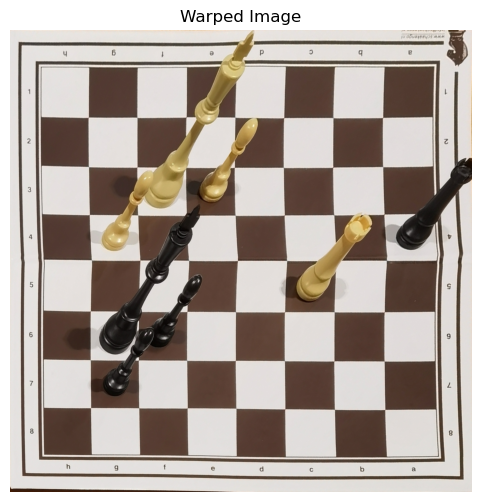

In [ ]:
output_size = 3024

dst = np.array([
        [0, 0],
        [output_size - 1, 0],
        [output_size - 1, output_size - 1],
        [0, output_size - 1]
    ], dtype="float32")

M = cv2.getPerspectiveTransform(np.array(ordered_corners, dtype="float32"), dst)
warped = cv2.warpPerspective(image, M, (output_size, output_size))
warped_rgb = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.title("Warped Image")   
plt.imshow(warped_rgb)
plt.axis('off')
plt.show()

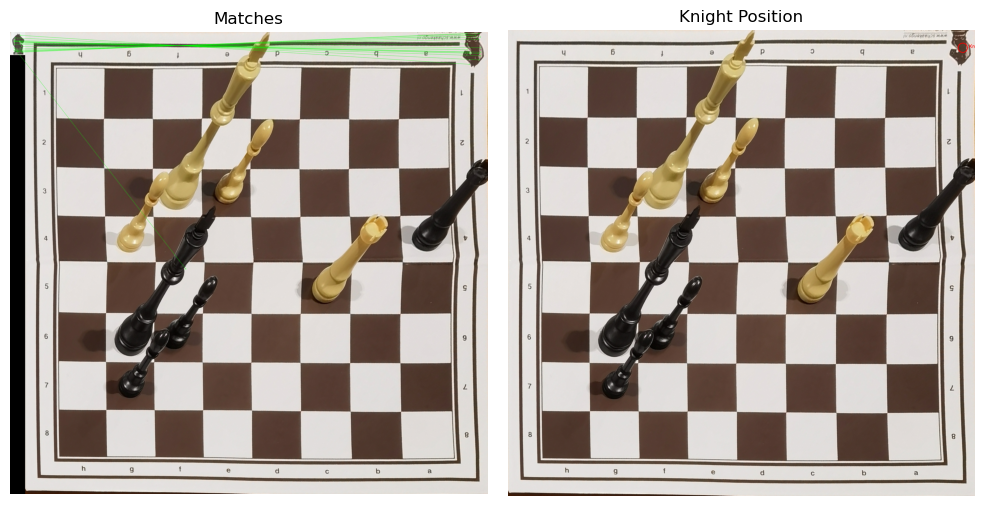

Knight found at position: (2944, 121)


In [ ]:
import cv2
import numpy as np

# Load images - replace these paths with your actual images
knight_template = cv2.imread("knight2.png", cv2.IMREAD_GRAYSCALE)  # Your knight symbol

chessboard_img= cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
chessboard_color = warped.copy()

# Color versions for display
knight_template_color = cv2.imread("knight2.png")


# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find keypoints and descriptors
kp1, des1 = sift.detectAndCompute(knight_template, None)
kp2, des2 = sift.detectAndCompute(chessboard_img, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)  # Higher = more accurate but slower

flann = cv2.FlannBasedMatcher(index_params, search_params)

# Perform matching
matches = flann.knnMatch(des1, des2, k=2)

# Apply ratio test (Lowe's criteria)
good_matches = []
ratio_threshold = 0.7  # Adjust this if needed
for m, n in matches:
    if m.distance < ratio_threshold * n.distance:
        good_matches.append(m)

# Draw matches
match_output = cv2.drawMatches(
    knight_template_color, kp1, 
    chessboard_color, kp2,
    good_matches, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    matchColor=(0, 255, 0)  # Green matches
)

# Find the knight location (average of good matches)
if len(good_matches) > 0:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    # Calculate average position
    knight_position = np.median(dst_pts, axis=0)[0]
    
    # Draw a circle at the found position
    cv2.circle(chessboard_color, (int(knight_position[0]), int(knight_position[1])), 
               30, (0, 0, 255), 3)
    cv2.putText(chessboard_color, "Knight", 
               (int(knight_position[0]) + 40, int(knight_position[1])),
               cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Matches")
match_output = cv2.cvtColor(match_output, cv2.COLOR_BGR2RGB)
plt.imshow(match_output)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Knight Position")
chessboard_color = cv2.cvtColor(chessboard_color, cv2.COLOR_BGR2RGB)
plt.imshow(chessboard_color)
plt.axis('off')
plt.tight_layout()
plt.show()

# Print position if found
if len(good_matches) > 0:
    print(f"Knight found at position: ({int(knight_position[0])}, {int(knight_position[1])})")
else:
    print("Knight not found - try adjusting the ratio threshold")

Knight position: (2944.02978515625, 121.20462036132812) | Center: (1512, 1512)
Rotating 180º to place the knight in the bottom-left corner


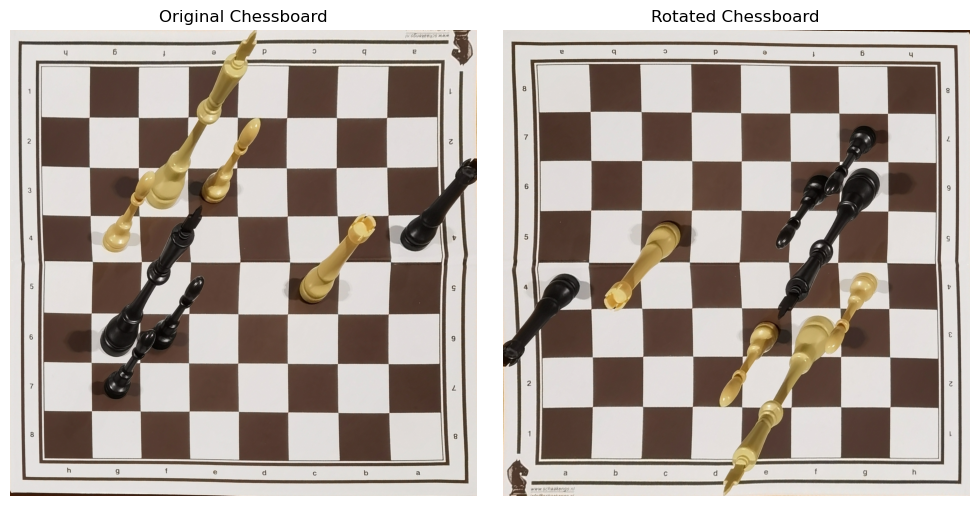

In [ ]:
def rotate_knight_to_bottom_left(image, knight_pos):
    h, w = image.shape[:2]
    cx, cy = w // 2, h // 2
    
    x, y = knight_pos 

    print(f"Knight position: ({x}, {y}) | Center: ({cx}, {cy})")

    if x < cx and y < cy:
        angle = 90  
    elif x >= cx and y < cy:
        angle = 180 
    elif x >= cx and y >= cy:
        angle = 270 
    else:
        angle = 0  

    print(f"Rotating {angle}º to place the knight in the bottom-left corner")

    if angle == 90:
        rotated = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif angle == 180:
        rotated = cv2.rotate(image, cv2.ROTATE_180) 
    elif angle == 270:
        rotated = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE) 
    else:
        rotated = image.copy() 

    return rotated


rotated_chessboard = rotate_knight_to_bottom_left(warped, knight_position)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Chessboard")
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)
plt.imshow(warped)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Rotated Chessboard")
rotated_chessboard = cv2.cvtColor(rotated_chessboard, cv2.COLOR_BGR2RGB)
plt.imshow(rotated_chessboard)
plt.axis('off')
plt.tight_layout()
plt.show()